# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.003517 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in ['node', 'line', 'source', 'sym_load']:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array('input', component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.030443 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/alliander-opensource/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.014828 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.002081 s
{'line': 2000, 'node': 2001, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.007070 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Linear Power Flow is 0.001291 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile
n_scenarios = 1000
dti = pd.date_range("2018-01-01", periods=n_scenarios, freq="H")
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2018-01-01 00:00:00,9.900342e+05,1.048602e+06,920506.937995,986692.143929,1.075788e+06,904083.484893,930774.720454,1.063826e+06,1.010278e+06,1.033228e+06,...,9.937693e+05,1.074708e+06,1.043847e+06,918260.910957,908055.135017,1.004874e+06,948871.854578,1.099617e+06,919593.919387,1.087314e+06
2018-01-01 01:00:00,9.981847e+05,1.021790e+06,920392.353321,971276.045030,1.087215e+06,892337.857467,956620.161544,1.059287e+06,1.027236e+06,1.007402e+06,...,9.992336e+05,1.081536e+06,1.053978e+06,930695.492147,892657.971682,9.905236e+05,930065.929785,1.095013e+06,931790.168674,1.085268e+06
2018-01-01 02:00:00,9.993507e+05,1.043172e+06,932436.718665,971200.957534,1.053979e+06,890873.662294,931136.628591,1.043565e+06,1.007379e+06,1.012910e+06,...,9.966675e+05,1.060775e+06,1.048622e+06,922851.428364,920216.785931,9.920078e+05,933642.283177,1.102636e+06,916612.043266,1.095780e+06
2018-01-01 03:00:00,9.790038e+05,1.031357e+06,913153.296488,972421.503035,1.085218e+06,907983.800406,932932.867994,1.050043e+06,1.011190e+06,1.016077e+06,...,1.008641e+06,1.081926e+06,1.063342e+06,916515.921890,893036.121321,9.985788e+05,937040.375473,1.105822e+06,931601.059596,1.072049e+06
2018-01-01 04:00:00,1.008588e+06,1.029239e+06,909379.429399,963961.017730,1.079495e+06,905355.249637,954303.400364,1.064197e+06,1.023507e+06,1.011451e+06,...,1.000835e+06,1.076796e+06,1.033039e+06,902657.769767,893599.538701,9.945147e+05,938186.195464,1.078605e+06,936620.916890,1.100695e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-11 11:00:00,1.003749e+06,1.050641e+06,922893.902775,974537.751092,1.070538e+06,910025.641474,909529.705362,1.071191e+06,1.014904e+06,1.018118e+06,...,1.012363e+06,1.075220e+06,1.041027e+06,910868.301884,906449.208767,9.771936e+05,937511.562197,1.083155e+06,910101.696527,1.096115e+06
2018-02-11 12:00:00,9.937937e+05,1.030979e+06,916400.618573,974804.679640,1.071412e+06,906029.623541,945510.813315,1.060048e+06,1.020910e+06,1.021651e+06,...,1.008512e+06,1.070525e+06,1.038106e+06,919172.871881,906002.916087,9.835029e+05,928191.702807,1.087786e+06,922368.366154,1.060389e+06
2018-02-11 13:00:00,9.795163e+05,1.052601e+06,913093.052173,980750.378304,1.084522e+06,907528.244763,933083.834018,1.049739e+06,9.991869e+05,1.015409e+06,...,1.008633e+06,1.069692e+06,1.053403e+06,920476.290971,907895.648076,9.970812e+05,943927.372554,1.069504e+06,912110.017565,1.088224e+06
2018-02-11 14:00:00,9.877240e+05,1.042637e+06,904379.936239,975182.032075,1.072301e+06,910586.606971,938433.977197,1.043476e+06,1.014020e+06,9.981809e+05,...,9.912740e+05,1.086042e+06,1.065330e+06,938640.958464,904495.267728,9.861579e+05,938357.038296,1.084988e+06,915906.523532,1.099236e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,9.976813e+05,1.036124e+06,917720.109367,974861.226194,1.060271e+06,903024.116889,932604.144063,1.077329e+06,1.028333e+06,1.010996e+06,...,1.007420e+06,1.077879e+06,1.038832e+06,917920.552695,927402.014858,989693.665549,929495.347496,1.100309e+06,935282.789673,1.092396e+06
2022-01-01 01:00:00,9.974840e+05,1.050707e+06,920804.697928,973394.613906,1.061338e+06,891638.267516,926641.966489,1.059691e+06,1.011827e+06,1.014826e+06,...,9.965012e+05,1.074256e+06,1.063221e+06,924867.602221,907365.053153,982444.138605,945426.492900,1.082009e+06,933278.830861,1.109367e+06
2022-01-01 02:00:00,9.814843e+05,1.055490e+06,916083.630203,945419.107152,1.066053e+06,906290.044499,947115.153989,1.054496e+06,1.018502e+06,1.011002e+06,...,9.856276e+05,1.088140e+06,1.048449e+06,925474.231894,918495.075940,996253.190203,932236.211483,1.093680e+06,948039.705502,1.094913e+06
2022-01-01 03:00:00,1.004192e+06,1.045963e+06,913569.907947,971507.890750,1.063087e+06,910435.920481,931063.308433,1.059586e+06,1.023738e+06,1.010450e+06,...,9.970751e+05,1.085188e+06,1.059225e+06,904878.151524,896800.972166,988833.064207,934888.663118,1.104079e+06,914534.419063,1.102173e+06
2022-01-01 04:00:00,9.918983e+05,1.060045e+06,921867.055614,963805.341475,1.061735e+06,903186.439912,916409.689161,1.038874e+06,1.031315e+06,1.039239e+06,...,9.978154e+05,1.088539e+06,1.049445e+06,919370.688276,909545.042091,975095.315749,916832.815971,1.090247e+06,920763.748421,1.086316e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,9.877404e+05,1.022794e+06,915449.443270,965349.376848,1.056592e+06,907901.781111,921254.063034,1.049414e+06,1.010302e+06,1.008789e+06,...,9.992617e+05,1.087876e+06,1.039821e+06,936674.558198,909599.268367,985775.520230,931294.920253,1.067336e+06,923209.621221,1.080739e+06
2022-02-11 12:00:00,9.937950e+05,1.037807e+06,914689.357280,971468.103399,1.087882e+06,894157.067619,934644.131021,1.050972e+06,1.024019e+06,9.975883e+05,...,1.013403e+06,1.064923e+06,1.057127e+06,930501.970292,909703.901617,986858.841569,952420.374257,1.088410e+06,930224.409055,1.079855e+06
2022-02-11 13:00:00,1.003954e+06,1.040744e+06,907542.352313,968076.787778,1.066504e+06,899243.400405,948820.855485,1.033832e+06,1.017262e+06,1.020928e+06,...,1.005784e+06,1.093643e+06,1.044750e+06,923595.591948,909228.415345,986769.240140,932046.477684,1.098206e+06,921646.076991,1.092476e+06
2022-02-11 14:00:00,9.813388e+05,1.047902e+06,919300.870352,960348.313999,1.050607e+06,917058.614405,928485.168161,1.053488e+06,1.022144e+06,1.012178e+06,...,1.007843e+06,1.039592e+06,1.038737e+06,920160.338435,897930.144937,993666.221001,933505.194361,1.076251e+06,923381.985349,1.091090e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [11]:
# Initialize an empty load profile
load_profile = initialize_array("update", "sym_load", df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {"sym_load": load_profile}

In [12]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 3.779354 s


In [13]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 4.301806 s


In [14]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 1.403236 s


## Plotting batch results

Lets say we wish to plot the loading of the `line 7` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

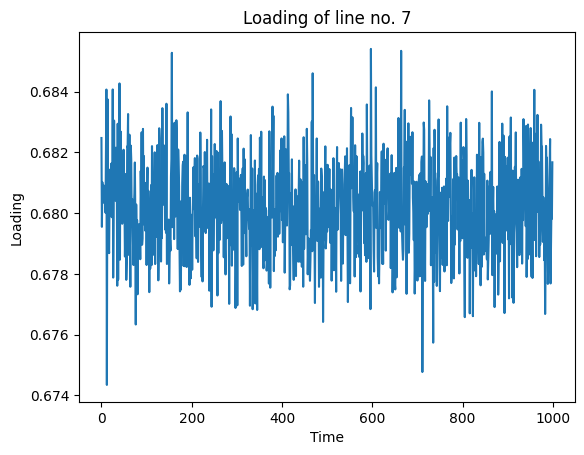

In [15]:
result_loading = output_data["line"]["loading"][:,6]
plt.plot(result_loading)
plt.title('Loading of line no. 7')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line 7` is greater than `68.4%`

In [16]:
ind = np.where(result_loading > 0.684)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-01 11:00:00', '2022-01-02 01:00:00',
               '2022-01-02 16:00:00', '2022-01-07 12:00:00',
               '2022-01-20 12:00:00', '2022-01-25 21:00:00',
               '2022-01-26 08:00:00', '2022-01-28 16:00:00',
               '2022-02-06 01:00:00', '2022-02-09 23:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [17]:
n_lines = len(input_data["line"])

# Initialize an empty line profile
line_profile = initialize_array("update", "line", (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data["line"]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {"line": line_profile}

In [18]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 7.291478 s


In [19]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 10.256861 s


In [20]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 2.821193 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [21]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 9.473211 s
Execution time for Single thread is 9.819530 s
Execution time for Two threads in parallel is 5.541908 s
Execution time for Four threads in parallel is 4.152572 s
Execution time for Use number of threads based the machine hardware is 3.406851 s
